In [2]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
print(sys.path)
import numpy as np
import os
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
from pyvis.network import Network
import zipfile 
from bioservices import KEGG
from K_func import translate_ko_terms

'''
Data prep and feature mapping
'''

os.chdir('../Datasets')
# Paths 2 files
zip_file_path_KO = "terms_KO.zip"
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'assembledDataset.zip'
csv_file_name_traits = 'assembledDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)


# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.07)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, low_memory=False, sep=';')

# Handle missing values and prepare data for trophic levels
traits['trophy'] = traits['trophy'].str.lower()  
traits = traits.dropna(subset=['trophy'])

# Define trophys
trophic_levels = ['photo', 'chemo', 'litho', 'hetero', 'organo', 'auto']

# store data for each trophic level
binary_labels = {}

for trophy in trophic_levels:
    binary_labels[trophy] = traits['trophy'].apply(lambda x: 1 if trophy in x else 0)

# create dataframe
y = pd.DataFrame(binary_labels)

# Align X (features) and Y (labels) based on common keys
common_keys = X_filtered_df.index.intersection(y.index)
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys]

# Ensures alignment
assert X_aligned.shape[0] == Y_aligned.shape[0], "X and Y are not aligned"

print(X_aligned.shape)
print(Y_aligned.shape)

traits.dropna(subset='trophy').query("database =='bacdive'")['trophy'].value_counts().head(10)

['c:\\Users\\Elijah\\Documents\\THESIS\\Eliah-Masters\\KOs', 'C:\\Program Files\\PerkinElmerInformatics\\ChemOffice2020\\ChemScript\\Lib', 'c:\\Python312\\python312.zip', 'c:\\Python312\\DLLs', 'c:\\Python312\\Lib', 'c:\\Python312', '', 'C:\\Users\\Elijah\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\Elijah\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\Elijah\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Elijah\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Python312\\Lib\\site-packages', '../Data_Feature', '../Datasets', '../Data_Feature', '../Datasets']
Features with zero variance after filtering: 0
(88, 3892)
(88, 6)


trophy
chemoorganotroph          175
chemoheterotroph           61
heterotroph                53
chemoorganoheterotroph     40
chemolithoautotroph        34
chemoautolithotroph         8
organoheterotroph           6
methylotroph                5
phototroph                  5
autotroph                   5
Name: count, dtype: int64

In [ ]:
# Check if Y_aligned is a DataFrame with multiple columns
if isinstance(Y_aligned, pd.DataFrame):
    # Iterate over each column in Y_aligned (representing different trophy levels or binary labels)
    for label_column in Y_aligned.columns:
        print(f"\nCalculating Pearson correlation for {label_column}...")

        # Extract the specific label column
        label_data = Y_aligned[label_column]
        
        # Check the class distribution in the current label column
        class_distribution = label_data.value_counts()
        print(f"Class distribution in {label_column}:", class_distribution)
        
        # Check unique labels in the current label column
        unique_labels = np.unique(label_data)
        print(f"Unique labels in {label_column}: {unique_labels}")
        
        # Initialize the LabelEncoder and transform the data from categorical
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(label_data)
        
        # Check data once label encoding is done
        print(f"Encoded data of {label_column}: {np.unique(encoded_labels)}")
        
        # Calculate Pearson correlation coefficients
        corr_coefficients = []  # Collect coefficients for the current label column
        
        for column in X_aligned.columns:
            # Calculate Pearson's r and p-value for each feature in X_aligned with the current label
            r, p = pearsonr(X_aligned[column], encoded_labels)
            corr_coefficients.append(r)
        
        # Plotting the histogram of Pearson correlation coefficients for the current label column
        plt.figure(figsize=(10, 6))
        plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
        plt.title(f'Correlations for {label_column}')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

else:
    # If Y_aligned is not a DataFrame (e.g., it's a single column Series), handle it as before
    print("Y_aligned is not a DataFrame with multiple columns. Proceeding with single column...")

    # Check class distribution in Y_aligned
    class_distribution = Y_aligned.value_counts()
    print("Class distribution in Y_aligned:", class_distribution)

    # Check unique labels in Y_aligned
    unique_labels = np.unique(Y_aligned)
    print(f"Unique labels in Y_aligned: {unique_labels}")

    # Initialize the LabelEncoder and transform the data from categorical
    label_encoder = LabelEncoder()
    Y_aligned = label_encoder.fit_transform(Y_aligned)

    # Check data once label encoding is done
    print(f"Data of Y_aligned: {np.unique(Y_aligned)}")

    # Calculate Pearson correlation coefficients
    corr_coefficients = []  # Collect coefficients from X_aligned and Y_aligned calculations

    for column in X_aligned.columns:
        # Calculate Pearson's r and p-value
        r, p = pearsonr(X_aligned[column], Y_aligned)
        corr_coefficients.append(r)

    # Plotting the histogram of Pearson correlation coefficients
    plt.figure(figsize=(10, 6))
    plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
    plt.title('Correlations')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [ ]:
def train_and_evaluate(X_aligned, Y_aligned, trophic_levels):
    results = {}

    for trophic_level in trophic_levels:
        print(f"Processing trophic level: {trophic_level}")
        
        # Binary labels for the current trophic level
        Y_current = Y_aligned[trophic_level].values
        
        # Split the data into training and testing sets
        X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_current, test_size=0.3, random_state=42, stratify=Y_current)
        
        # Remove constant features again after splitting
        #constant_filter = VarianceThreshold(threshold=0)  # Uses threshold=0 to remove any remaining constant features
        #X_train = constant_filter.fit_transform(X_train)
        #X_test = constant_filter.transform(X_test)
        
        # Define a pipeline
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', RandomForestClassifier())
        ])

        # Define a parameter grid to search over
        param_grid = [
            {
                'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
                'estimator': [RandomForestClassifier(random_state=42)],
                'estimator__n_estimators': [100, 200],
                'estimator__max_depth': [5, 10, None]
            },
            {
                'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
                'estimator': [SVC(random_state=42)],
                'estimator__C': [0.1, 1, 10],
                'estimator__kernel': ['linear', 'rbf'],
                'estimator__gamma': ['scale', 'auto']
            },
            {
                'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
                'estimator': [LogisticRegression()],
                'estimator__C': [0.01, 0.1, 1, 10, 100]
            },
            {
                'select_k__k': [10, 50, 100, 200, 300, 500, 1000],
                'estimator': [BernoulliNB()],
                'estimator__alpha': [0.01, 0.1, 1.0, 10.0],
                'estimator__binarize': [0.0]
            }
        ]
        
        # Grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, Y_train)

        print(f"Best parameters found for {trophic_level}:", grid_search.best_params_)
        print(f"Best cross-validation score for {trophic_level}: {grid_search.best_score_:.3f}")

        # Evaluate the best model on the test set
        best_model = grid_search.best_estimator_
        Y_pred = best_model.predict(X_test)

        mcc = matthews_corrcoef(Y_test, Y_pred)
        print(f"Matthews Correlation Coefficient for {trophic_level}: {mcc:.3f}")

        # Display confusion matrix using Seaborn heatmap for better visualization
        cm = confusion_matrix(Y_test, Y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix for {trophic_level} Classifier')
        plt.show()
        
        # Store results
        results[trophic_level] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'mcc': mcc,
            'confusion_matrix': cm
        }

    # Print final results
    for trophic_level, result in results.items():
        print(f"Trophic Level: {trophic_level}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best Cross-Validation Score: {result['best_score']:.3f}")
        print(f"MCC: {result['mcc']:.3f}")
        print(f"Confusion Matrix:\n{result['confusion_matrix']}\n")

# Run the function with your data
train_and_evaluate(X_aligned, Y_aligned, trophic_levels)

In [ ]:
''' Finding best traits using f-scpre'''

'''# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=10)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

#Plot for visualizing distribution and importance of best traits

# Translate selected KO terms to their descriptions
selected_ko_terms_list = list(sorted_features)  
ko_descriptions_mapping = translate_ko_terms(selected_ko_terms_list)


# Replace KO terms with their descriptions for plotting
translated_sorted_features = [ko_descriptions_mapping[ko] for ko in sorted_features]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(translated_sorted_features)), sorted_scores)
plt.xticks(range(len(translated_sorted_features)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('F-scores')
plt.title('Top 50 KO Descriptions by F-score')
plt.tight_layout()
plt.show()
'''

In [ ]:
# Dictionaries to store selected features for each trophic level and each model
selected_features_rf_dict = {}
selected_features_lr_dict = {}

''' Model-based Feature Importance '''

# For RandomForestClassifier
for trophic in trophic_levels:
    print(f"\nFeature importance for {trophic} (Random Forest):")
    
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_aligned, Y_aligned[trophic].values)
    
    feature_importances_rf = model_rf.feature_importances_
    sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
    
    top_k_indices_rf = sorted_indices_rf[:10]
    selected_features_rf = X_aligned.columns[top_k_indices_rf]
    
    sorted_scores_rf = feature_importances_rf[top_k_indices_rf]
    
    print(f"Top KO terms for {trophic} (Random Forest):")
    print(selected_features_rf)
    
    translated_sorted_features_rf = translate_ko_terms(list(selected_features_rf))
    
    # Store selected features for the current trophic level in the RF dictionary
    selected_features_rf_dict[trophic] = selected_features_rf
    
    # Plotting for Random Forest
    plt.figure(figsize=(10, 8))
    plt.bar(range(len(selected_features_rf)), sorted_scores_rf)
    plt.xticks(range(len(selected_features_rf)), translated_sorted_features_rf, rotation='vertical', fontsize=8)
    plt.xlabel('KO Descriptions')
    plt.ylabel('Importance Scores')
    plt.title(f'Top 10 KO Descriptions for {trophic} (Random Forest)')
    plt.tight_layout()
    plt.show()

# For LogisticRegression
for trophic in trophic_levels:
    print(f"\nFeature importance for {trophic} using Logistic Regression:")
    
    lr_model = LogisticRegression()
    lr_model.fit(X_aligned, Y_aligned[trophic].values)
    
    lr_coefficients = lr_model.coef_[0]  # Coefficients for the binary classification task
    sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]
    
    # Select the top 10 features
    top_k_indices_lr = sorted_indices_lr[:10]
    selected_features_lr = X_aligned.columns[top_k_indices_lr]
    
    sorted_scores_lr = lr_coefficients[top_k_indices_lr]
    
    print(f"Top KO terms for {trophic} using Logistic Regression:")
    print(selected_features_lr)
    
    translated_sorted_features_lr = translate_ko_terms(list(selected_features_lr))
    
    # Store selected features for the current trophic level in the LR dictionary
    selected_features_lr_dict[trophic] = selected_features_lr
    
    # Plotting for Logistic Regression
    plt.figure(figsize=(10, 8))
    plt.bar(range(len(translated_sorted_features_lr)), np.abs(sorted_scores_lr))
    plt.xticks(range(len(translated_sorted_features_lr)), translated_sorted_features_lr, rotation='vertical', fontsize=8)
    plt.xlabel('KO Descriptions')
    plt.ylabel('Coefficient Magnitudes')
    plt.title(f'Top 10 KO Descriptions for {trophic} using Logistic Regression')
    plt.tight_layout()
    plt.show()

# For choosing trophy
chosen_trophic_level = 'photo'  # Replace with  chosen trophic level, e.g., 'chemo', 'litho', etc.
chosen_model = 'rf'  # 'rf' for Random Forest, 'lr' for Logistic Regression

# Select the appropriate features based on the user's choice
if chosen_model == 'rf':
    selected_important_features = selected_features_rf_dict[chosen_trophic_level]
elif chosen_model == 'lr':
    selected_important_features = selected_features_lr_dict[chosen_trophic_level]


In [ ]:
# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

kegg = KEGG()

pathways = map_ko_to_pathways(selected_important_features)
translated_kos = translate_ko_terms(selected_important_features)  

# Creating the adjacency matrix with translated KO terms, including original KO term
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways ({chosen_trophic_level}, {chosen_model})')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways ({chosen_trophic_level}, {chosen_model})', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph(f"ko_network_{chosen_trophic_level}_{chosen_model}.html")

In [ ]:
'''
TROUBLE SHOOTING
'''  '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")'''

Processing trophic level: photo
  Using estimator: RandomForestClassifier
    Testing with k=1
    Testing with k=21
    Testing with k=41
    Testing with k=61
    Testing with k=81
    Testing with k=101
    Testing with k=121
    Testing with k=141
    Testing with k=161
    Testing with k=181
    Testing with k=201
    Testing with k=221
    Testing with k=241
    Testing with k=261
    Testing with k=281
    Testing with k=301
    Testing with k=321
    Testing with k=341
    Testing with k=361
    Testing with k=381
    Testing with k=401
    Testing with k=421
    Testing with k=441
    Testing with k=461
    Testing with k=481
    Testing with k=501
    Testing with k=521
    Testing with k=541
    Testing with k=561
    Testing with k=581
    Testing with k=601
    Testing with k=621
    Testing with k=641
    Testing with k=661
    Testing with k=681
    Testing with k=701
    Testing with k=721
    Testing with k=741
    Testing with k=761
    Testing with k=781
    Testing 

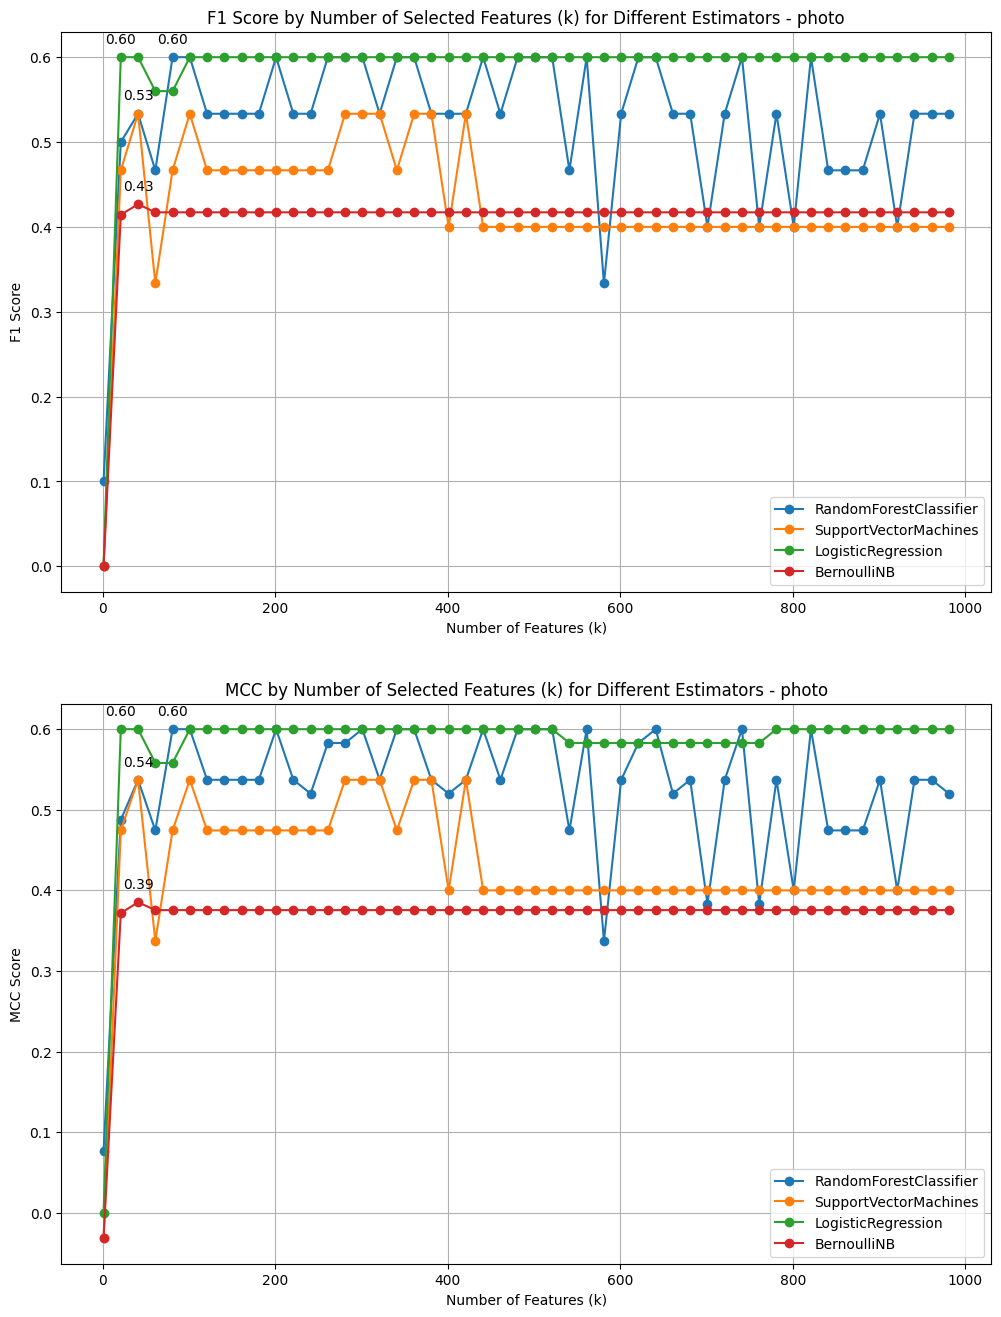

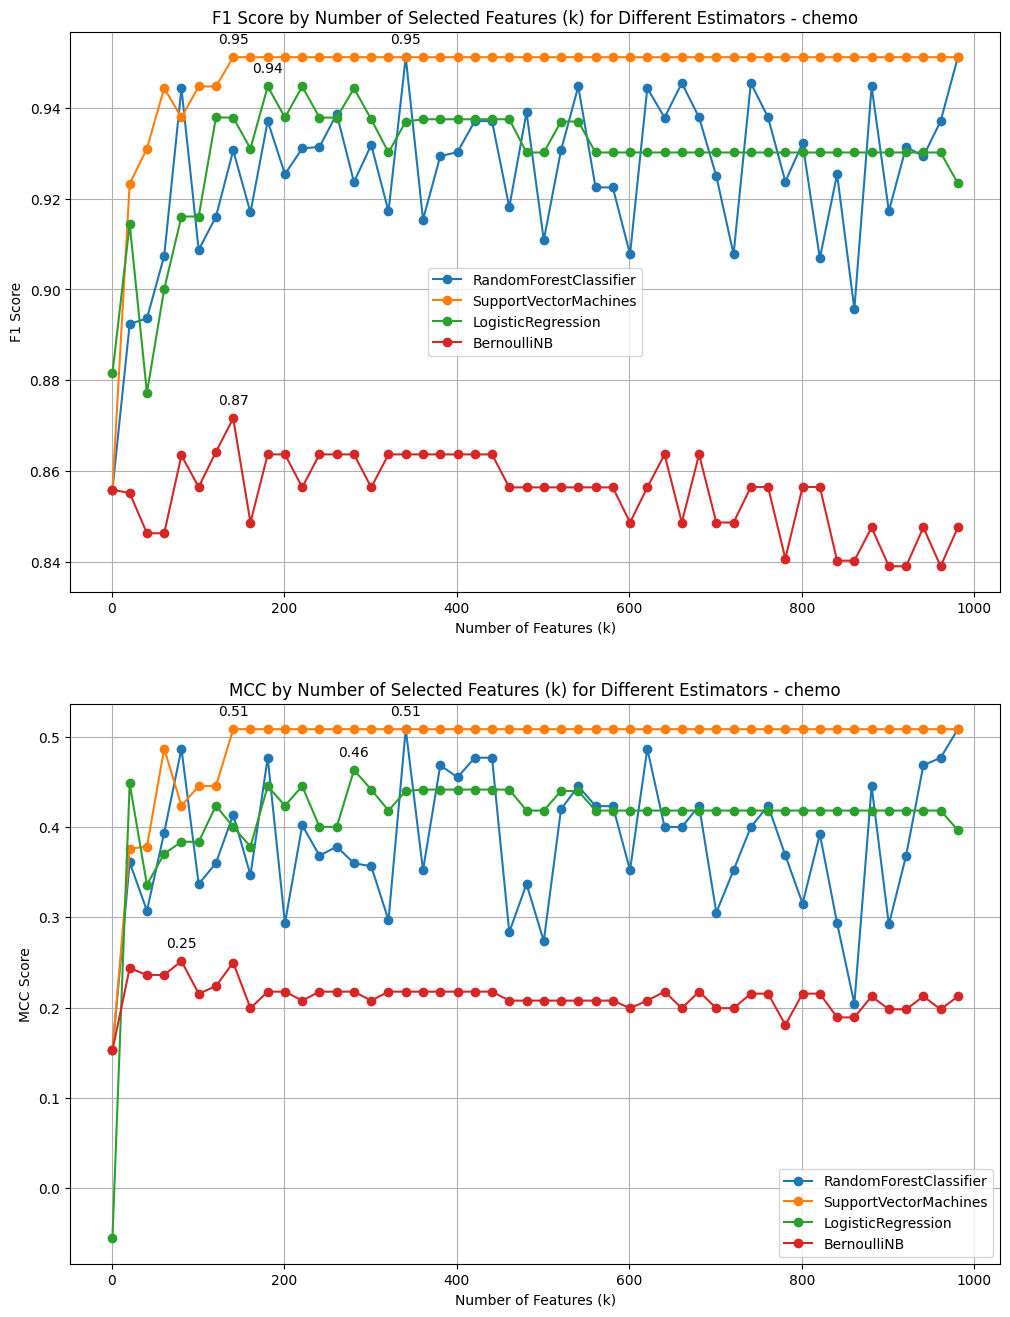

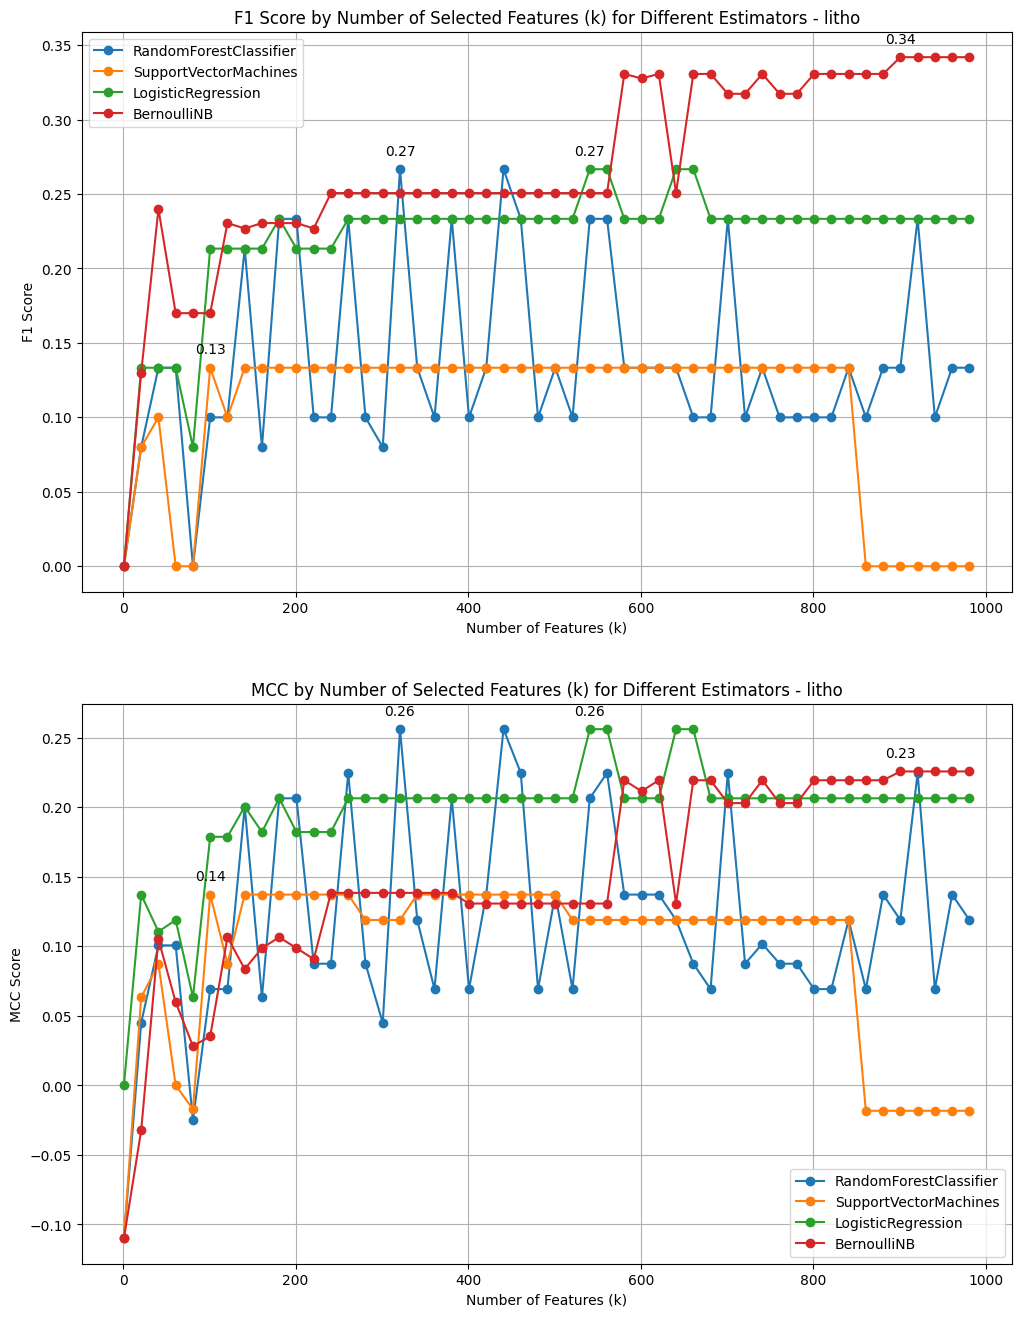

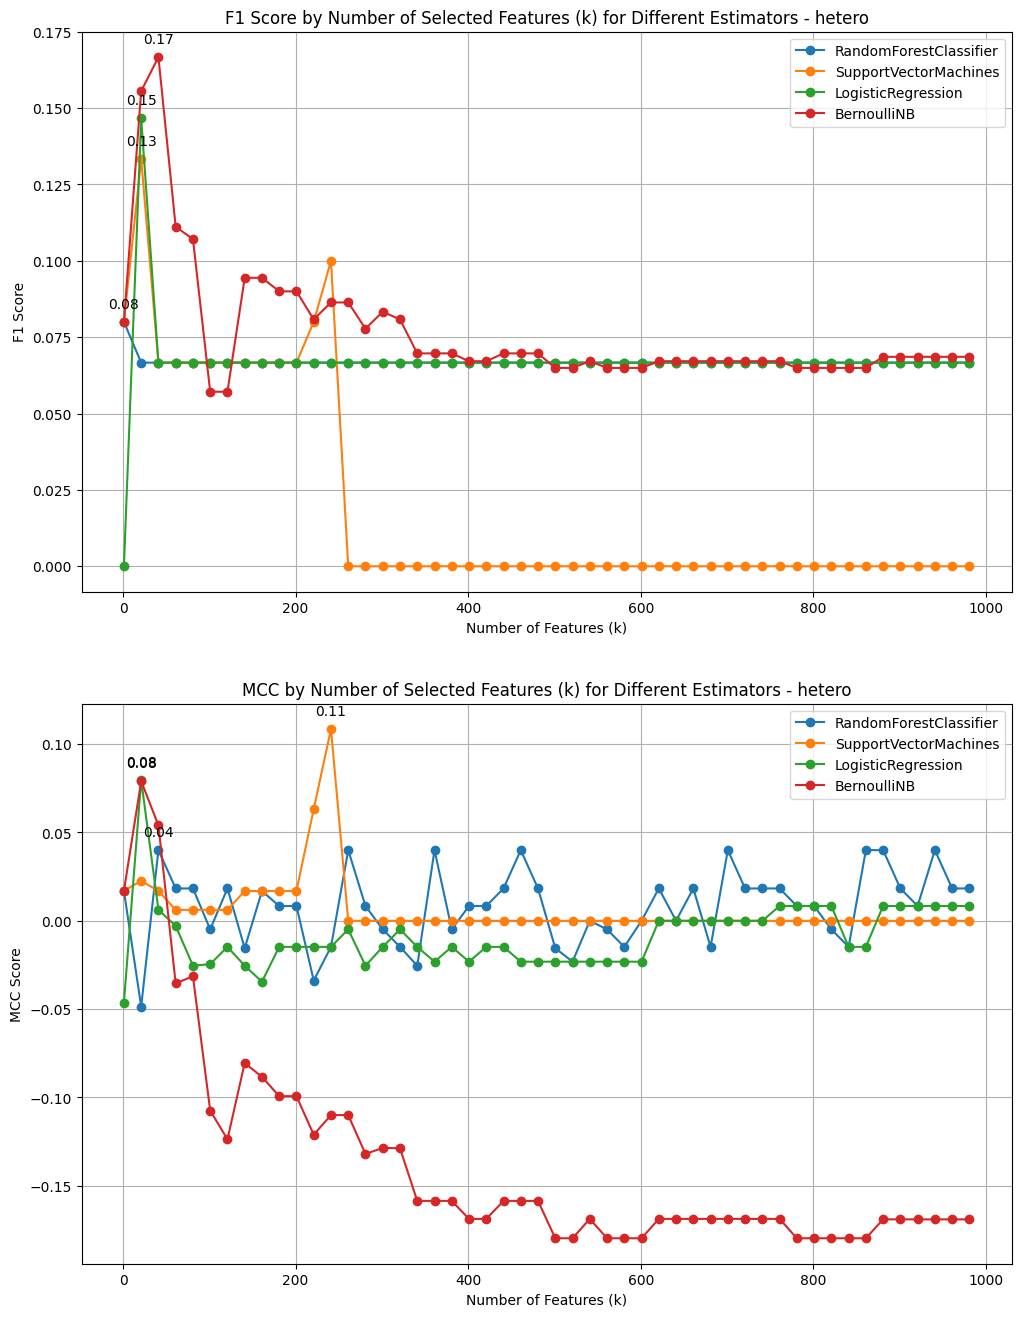

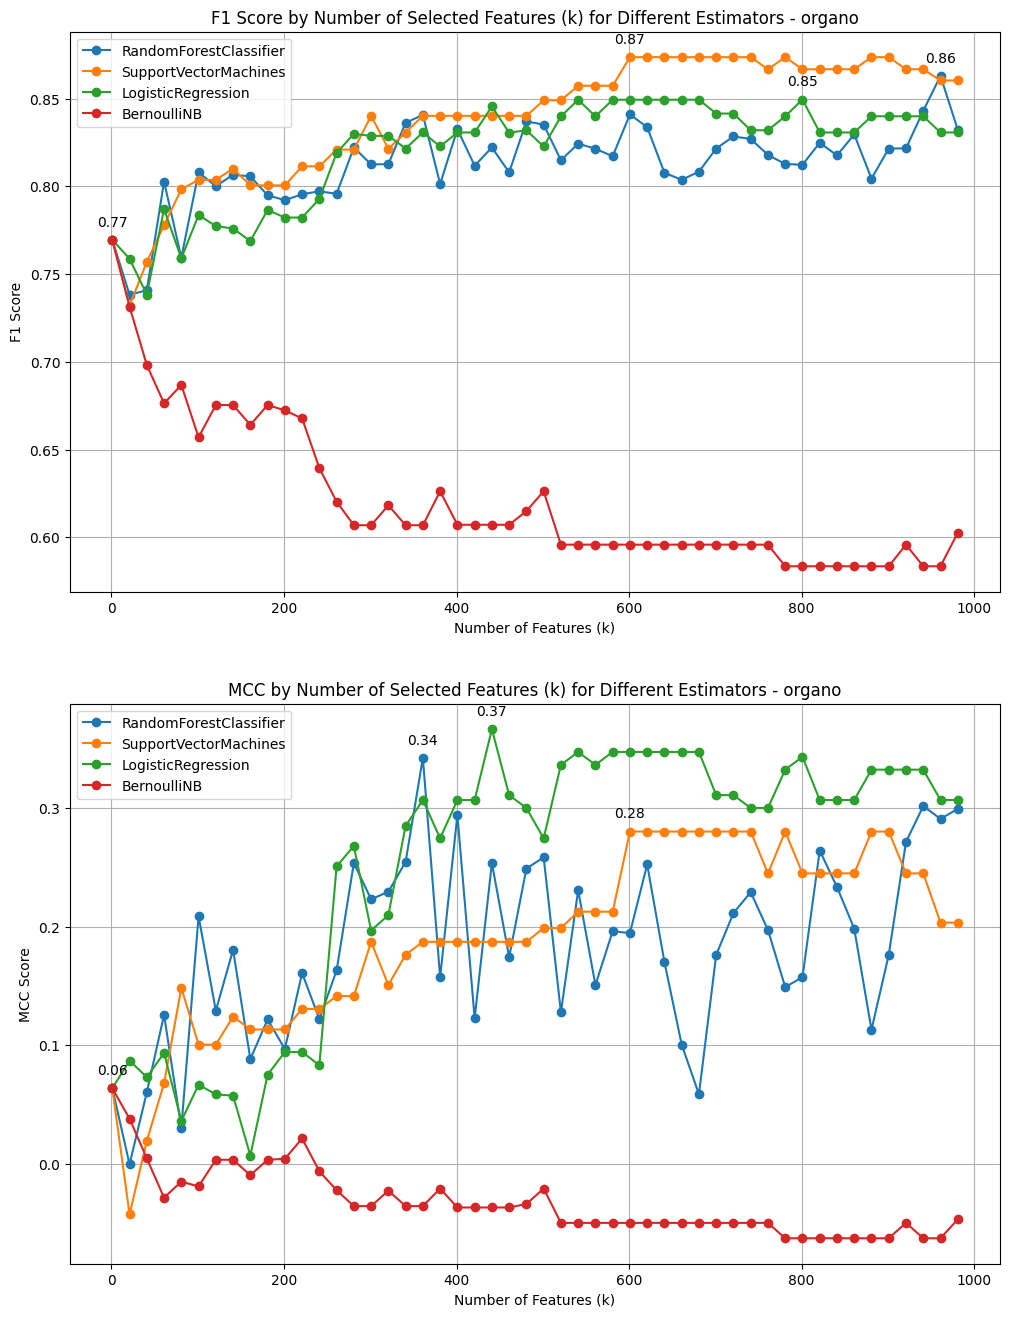

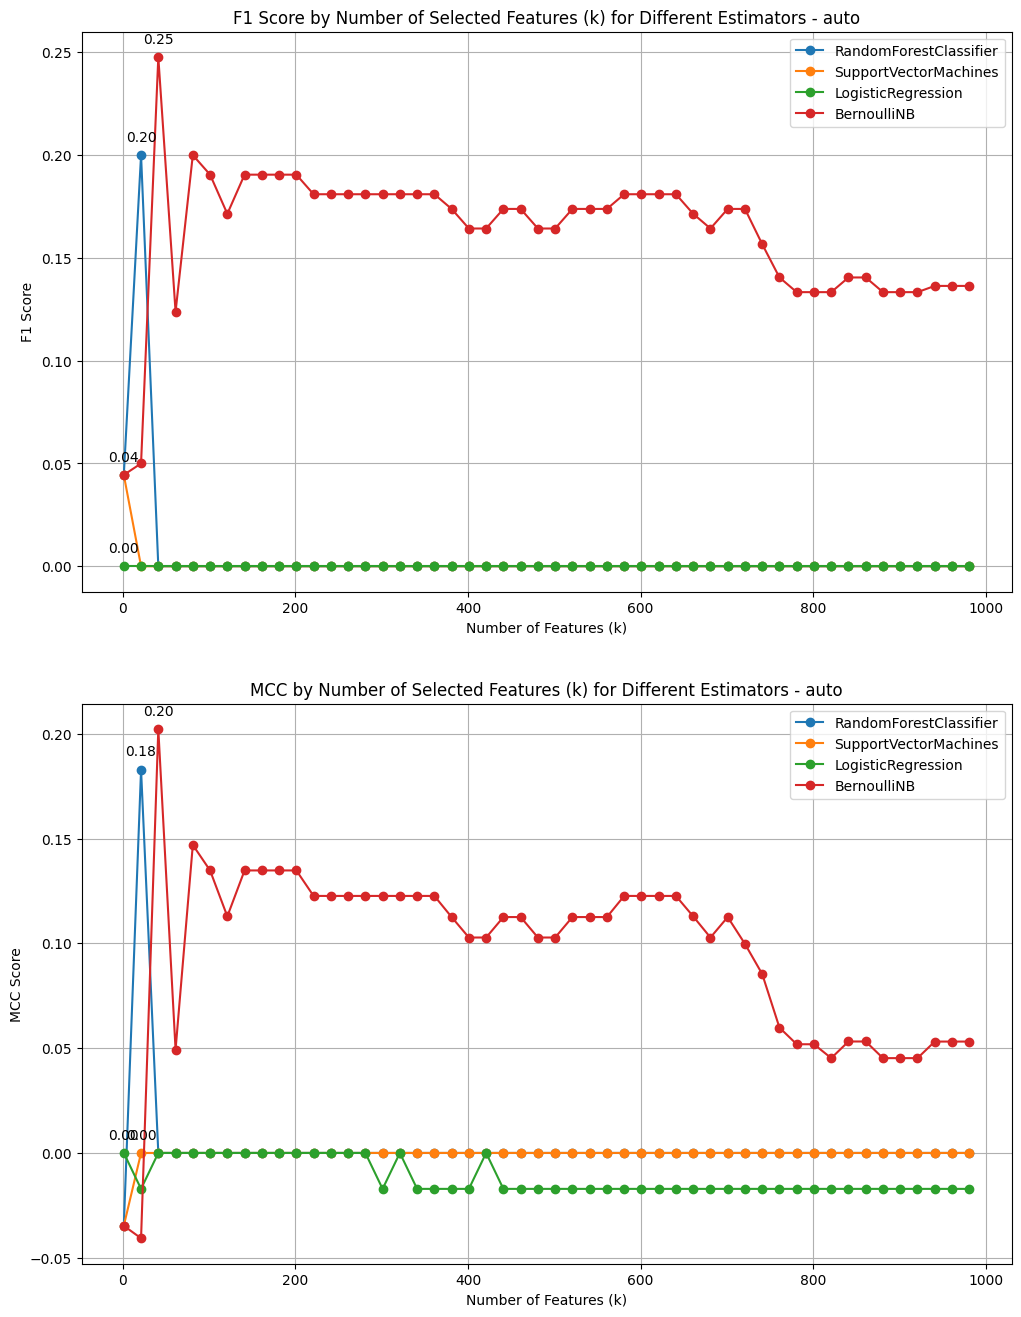

In [7]:
''' F1 and MCC plots '''

# Define the range of `k` values to explore
k_values = range(1, 1000, 20)

# Define base estimators to compare
base_estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Initialize results storage
results = {trophic: {name: {'f1': [], 'mcc': []} for name in base_estimators} for trophic in trophic_levels}

# Loop over each trophic level
for trophic in trophic_levels:
    print(f"Processing trophic level: {trophic}")
    
    Y_current = Y_aligned[trophic].values
    
    # Loop over each estimator
    for name, estimator in base_estimators.items():
        print(f"  Using estimator: {name}")
        
        # Loop over each `k` value
        for k in k_values:
            print(f"    Testing with k={k}")  # Debug print
            
            # Define the pipeline for the current estimator
            pipeline = Pipeline([
                ('select_k', SelectKBest(f_classif, k=k)),
                ('estimator', estimator)
            ])
            
            # Perform cross-validation for F1-score
            f1_scores = cross_val_score(pipeline, X_aligned, Y_current, cv=cv, scoring=make_scorer(f1_score, average='binary'), n_jobs=-1)
            results[trophic][name]['f1'].append(f1_scores.mean())
            
            # Perform cross-validation for MCC
            mcc_scores = cross_val_score(pipeline, X_aligned, Y_current, cv=cv, scoring=make_scorer(matthews_corrcoef), n_jobs=-1)
            results[trophic][name]['mcc'].append(mcc_scores.mean())

# Plotting the results for each trophic level and each estimator for both F1 and MCC
for trophic in trophic_levels:
    fig, ax = plt.subplots(2, 1, figsize=(12, 16))
    
    for name, scores in results[trophic].items():
        k_values_list = list(k_values)  # Convert range to list for indexing
        
        # F1 Plot
        finite_f1_scores = [score for score in scores['f1'] if np.isfinite(score)]
        finite_k_values_f1 = [k for k, score in zip(k_values_list, scores['f1']) if np.isfinite(score)]
        ax[0].plot(finite_k_values_f1, finite_f1_scores, marker='o', linestyle='-', label=name)
        
        # Highest F1 score
        if finite_f1_scores:  # Check if there are any finite scores
            max_f1_score = max(finite_f1_scores)
            max_f1_index = finite_f1_scores.index(max_f1_score)
            best_k_f1 = finite_k_values_f1[max_f1_index]
            ax[0].annotate(f'{max_f1_score:.2f}', (best_k_f1, max_f1_score), textcoords="offset points", xytext=(0,10), ha='center')
        
        # MCC Plot
        finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
        finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) if np.isfinite(score)]
        ax[1].plot(finite_k_values_mcc, finite_mcc_scores, marker='o', linestyle='-', label=name)

        # Highest MCC score
        if finite_mcc_scores:  # Check if there are any finite scores
            max_mcc_score = max(finite_mcc_scores)
            max_mcc_index = finite_mcc_scores.index(max_mcc_score)
            best_k_mcc = finite_k_values_mcc[max_mcc_index]
            ax[1].annotate(f'{max_mcc_score:.2f}', (best_k_mcc, max_mcc_score), textcoords="offset points", xytext=(0,10), ha='center')

    ax[0].set_title(f'F1 Score by Number of Selected Features (k) for Different Estimators - {trophic}')
    ax[0].set_xlabel('Number of Features (k)')
    ax[0].set_ylabel('F1 Score')

    ax[1].set_title(f'MCC by Number of Selected Features (k) for Different Estimators - {trophic}')
    ax[1].set_xlabel('Number of Features (k)')
    ax[1].set_ylabel('MCC Score')

    for a in ax:
        a.legend()
        a.grid(True)

    plt.show()

Processing estimator: RandomForestClassifier
  Testing with k=1
  Testing with k=21
  Testing with k=41
  Testing with k=61
  Testing with k=81
  Testing with k=101
  Testing with k=121
  Testing with k=141
  Testing with k=161
  Testing with k=181
  Testing with k=201
  Testing with k=221
  Testing with k=241
  Testing with k=261
  Testing with k=281
  Testing with k=301
  Testing with k=321
  Testing with k=341
  Testing with k=361
  Testing with k=381
  Testing with k=401
  Testing with k=421
  Testing with k=441
  Testing with k=461
  Testing with k=481
  Testing with k=501
  Testing with k=521
  Testing with k=541
  Testing with k=561
  Testing with k=581
  Testing with k=601
  Testing with k=621
  Testing with k=641
  Testing with k=661
  Testing with k=681
  Testing with k=701
  Testing with k=721
  Testing with k=741
  Testing with k=761
  Testing with k=781
  Testing with k=801
  Testing with k=821
  Testing with k=841
  Testing with k=861
  Testing with k=881
  Testing with k

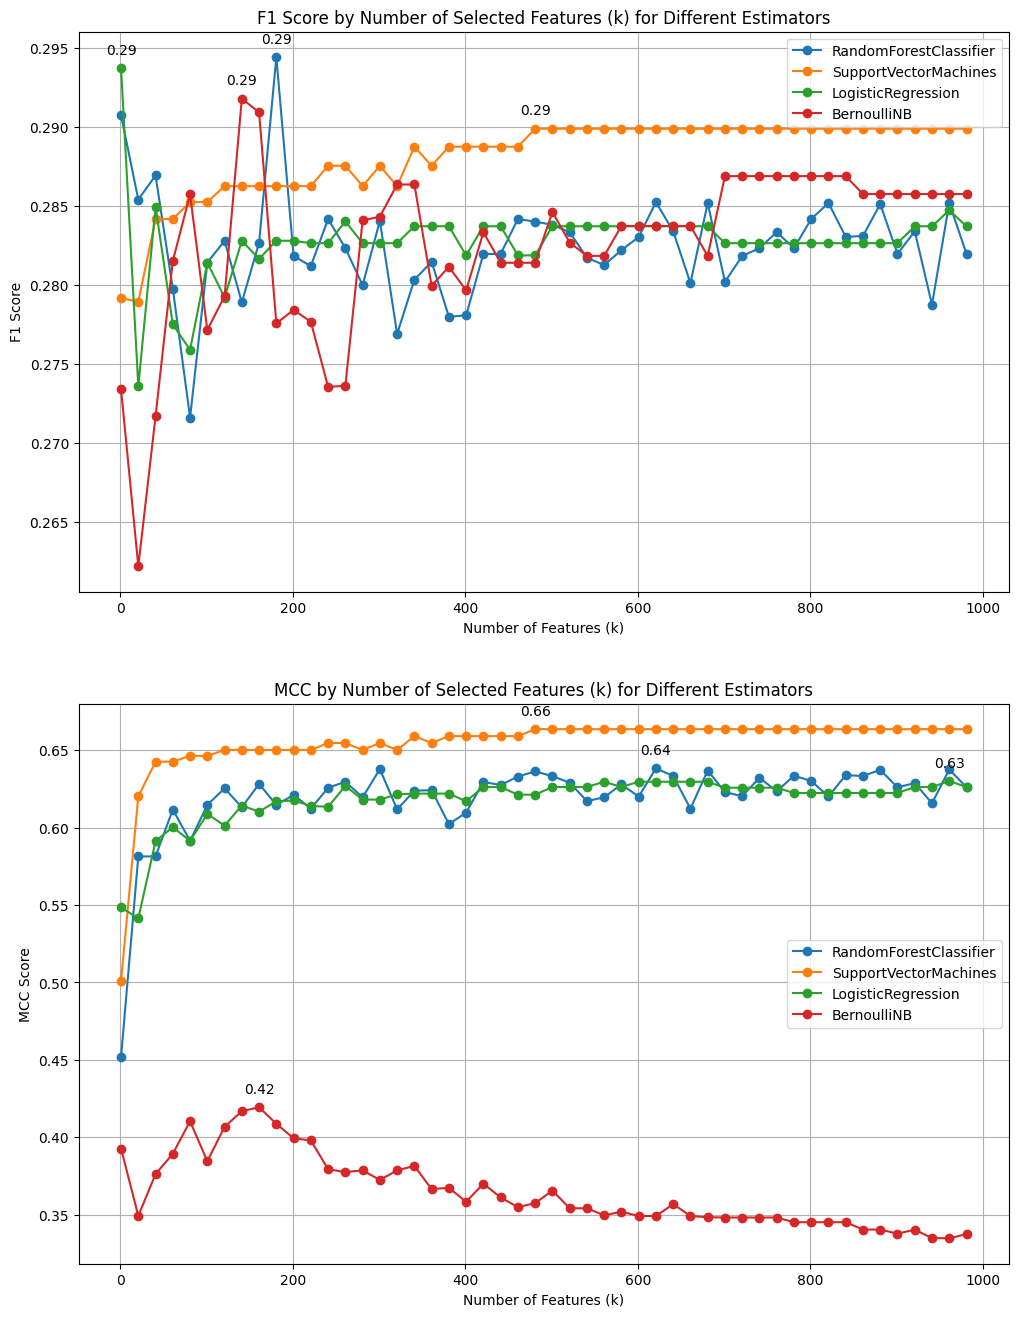

In [6]:
''' F1 and MCC plots with MultiOutputClassifier '''
import warnings
warnings.filterwarnings("ignore")


# Define the range of `k` values to explore
k_values = range(1, 1000, 20)

# Define base estimators to compare, wrapped with MultiOutputClassifier
base_estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store results for both F1 and MCC
results = {name: {'f1': [], 'mcc': []} for name in base_estimators}

# Initialize KFold
kf = KFold(n_splits=5)

# Loop over each estimator
for name, base_estimator in base_estimators.items():
    print(f"Processing estimator: {name}")
    
    # Loop over each `k` value
    for k in k_values:
        print(f"  Testing with k={k}")
        
        f1_scores = []
        mcc_scores = []
        
        # Manual cross-validation
        for train_index, test_index in kf.split(X_aligned):
            X_train, X_test = X_aligned.iloc[train_index], X_aligned.iloc[test_index]
            y_train, y_test = Y_aligned.iloc[train_index], Y_aligned.iloc[test_index]
            
            # Perform feature selection independently for each output
            selected_features = []
            for i in range(y_train.shape[1]):
                selector = SelectKBest(f_classif, k=k)
                X_train_selected = selector.fit_transform(X_train, y_train.iloc[:, i])
                X_test_selected = selector.transform(X_test)
                
                selected_features.append((X_train_selected, X_test_selected))
            
            # Stack selected features back together
            X_train_combined = np.hstack([f[0] for f in selected_features])
            X_test_combined = np.hstack([f[1] for f in selected_features])
            
            # Fit the model
            multi_output_model = MultiOutputClassifier(base_estimator)
            multi_output_model.fit(X_train_combined, y_train)
            y_pred = multi_output_model.predict(X_test_combined)
            
            # Calculate F1 and MCC for each output
            f1 = f1_score(y_test, y_pred, average='macro')
            mcc = matthews_corrcoef(y_test.values.ravel(), y_pred.ravel())
            
            f1_scores.append(f1)
            mcc_scores.append(mcc)
        
        # Store average F1 and MCC scores
        results[name]['f1'].append(np.mean(f1_scores))
        results[name]['mcc'].append(np.mean(mcc_scores))

# Plotting the results for each estimator for both F1 and MCC
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing
    
    # F1 Plot
    finite_f1_scores = [score for score in scores['f1'] if np.isfinite(score)]
    finite_k_values_f1 = [k for k, score in zip(k_values_list, scores['f1']) if np.isfinite(score)]
    ax[0].plot(finite_k_values_f1, finite_f1_scores, marker='o', linestyle='-', label=name)
    
    # Highest F1 score
    if finite_f1_scores:  # Check if there are any finite scores
        max_f1_score = max(finite_f1_scores)
        max_f1_index = finite_f1_scores.index(max_f1_score)
        best_k_f1 = finite_k_values_f1[max_f1_index]
        ax[0].annotate(f'{max_f1_score:.2f}', (best_k_f1, max_f1_score), textcoords="offset points", xytext=(0,10), ha='center')
    
    # MCC Plot
    finite_mcc_scores = [score for score in scores['mcc'] if np.isfinite(score)]
    finite_k_values_mcc = [k for k, score in zip(k_values_list, scores['mcc']) if np.isfinite(score)]
    ax[1].plot(finite_k_values_mcc, finite_mcc_scores, marker='o', linestyle='-', label=name)

    # Highest MCC score
    if finite_mcc_scores:  # Check if there are any finite scores
        max_mcc_score = max(finite_mcc_scores)
        max_mcc_index = finite_mcc_scores.index(max_mcc_score)
        best_k_mcc = finite_k_values_mcc[max_mcc_index]
        ax[1].annotate(f'{max_mcc_score:.2f}', (best_k_mcc, max_mcc_score), textcoords="offset points", xytext=(0,10), ha='center')

ax[0].set_title('F1 Score by Number of Selected Features (k) for Different Estimators')
ax[0].set_xlabel('Number of Features (k)')
ax[0].set_ylabel('F1 Score')

ax[1].set_title('MCC by Number of Selected Features (k) for Different Estimators')
ax[1].set_xlabel('Number of Features (k)')
ax[1].set_ylabel('MCC Score')

for a in ax:
    a.legend()
    a.grid(True)

plt.show()


Some info regarding the MCC vs F1 plot

Iterating Over Each Trophic Level: 
Iterates over each trophic level separately, performing the feature selection and cross-validation for each trophic level independently. 

Binary Classification for Each Trophic Level: 
Each model is trained and evaluated as a binary classification task (e.g., "Is it photo yes/no?") for each trophic level. This aligns with the multilabel setup where each trophic level is treated as a separate binary classification problem. 

Storing and Plotting Results: 
Results are stored separately for each trophic level, and plots are generated for each trophic level independently. 

In [ ]:
''' Plot for LR vs RFS

# Fit models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting to aligned matrixes
lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)

# Get coefficients and feature importances
logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_
sorted_indices_rf = np.argsort(rf_feature_importance)[::-1]
sorted_indices_lr = np.argsort(logistic_importance)[::-1]


top_k_indices_rf = sorted_indices_rf[:10]
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_rf = X_aligned.columns[top_k_indices_rf]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

print(selected_features_rf)
print(selected_features_lr)

sorted_scores_rf = rf_feature_importance[top_k_indices_rf]
sorted_scores_lr = logistic_importance[top_k_indices_lr]


# Normalize the importance scores
scaler = MinMaxScaler()
lr_importance_scaled = scaler.fit_transform(logistic_importance.reshape(-1, 1)).flatten()
rf_importance_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1)).flatten()

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(lr_importance_scaled, rf_importance_scaled, alpha=0.6, color='red')

# Line of best fit
m, b = np.polyfit(rf_importance_scaled, lr_importance_scaled, 1)
ax.plot(rf_importance_scaled, m*rf_importance_scaled + b, color='blue')
ax.grid(True)
ax.set_xlabel('Logistic Regression Importance Scores (LR)')
ax.set_ylabel('Random Forest Importance Scores (RFS)')
ax.set_title('Comparison of Feature Importance Scores')

plt.show()

# Important to remember

''' 

#Logistic Regression Coefficients: After normalizing, they represent the relative predictive strength of features, 
#but they lose their direct probabilistic interpretation.

#Random Forest Feature Importances: They indicate how much each feature contributes to the predictive accuracy of the model, 
#based on how much each feature decreases the impurity of the splits.

#Maybe test rankings of features instead of normalized values. Can compare and see which features are consistently considered
#important across both models
'''


# Rank the features by importance for each model
lr_ranking = np.argsort(logistic_importance)[::-1]  # argsort returns indices that would sort the array
rf_ranking = np.argsort(rf_feature_importance)[::-1]


# For visualization
import pandas as pd

feature_names = X_aligned.columns  # For feature names
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'LR_Rank': lr_ranking.argsort(),
    'RF_Rank': rf_ranking.argsort(),
    'LR_Score': logistic_importance[lr_ranking.argsort()],
    'RF_Score': rf_feature_importance[rf_ranking.argsort()]
})


# Select top features by rank threshold or specific indices if needed
top_n = 10
ranking_df['Top_LR'] = ranking_df['LR_Rank'] < top_n
ranking_df['Top_RF'] = ranking_df['RF_Rank'] < top_n

# Now print or use this DataFrame for visualization
print(ranking_df.head(20))  # Display the first 20 entries for checking

''' 
# Sorts based on logisitc regression rank
#ranking_df.sort_values('LR_Rank', inplace=True)
# Can also sort by 'RF_Rank' 
# Ranks from random forests
#print(ranking_df[['Feature', 'LR_Rank', 'RF_Rank']].head(100))
# This shows the top 20 features as ranked by logistic regression, alongside their ranks in random forest
'''

# To find features that are consistently considered important, look for low rank numbers in both models
consistently_important_features = ranking_df[(ranking_df['LR_Rank'] < 100) & (ranking_df['RF_Rank'] < 100)]
print(consistently_important_features)



"importance" in logistic regression is based on the magnitude of the coefficients (which reflect the odds of the outcome), 
#while in random forests, importance is derived from how much a feature decreases the impurity of the splits.
'''

In [ ]:
'''# Assume X_aligned and Y_aligned are defined and appropriate for model fitting

# Fit models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting to aligned matrices
lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)

# Get coefficients and feature importances
logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Rank the features by importance for each model
lr_ranking = np.argsort(logistic_importance)[::-1]  # argsort returns indices that would sort the array
rf_ranking = np.argsort(rf_feature_importance)[::-1]

# Normalize the importance scores
scaler = MinMaxScaler()
lr_importance_scaled = scaler.fit_transform(logistic_importance.reshape(-1, 1)).flatten()
rf_importance_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1)).flatten()


# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(lr_importance_scaled, rf_importance_scaled, alpha=0.6, color='red')

# Line of best fit
m, b = np.polyfit(rf_importance_scaled, lr_importance_scaled, 1)
ax.plot(rf_importance_scaled, m*rf_importance_scaled + b, color='blue')
ax.grid(True)
ax.set_xlabel('Logistic Regression Importance Scores (LR)')
ax.set_ylabel('Random Forest Importance Scores (RFS)')
ax.set_title('Comparison of Feature Importance Scores')

plt.show()


# For visualization
feature_names = X_aligned.columns  # Assuming your DataFrame columns are the feature names
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'LR_Rank': lr_ranking.argsort(),  # Convert indices to rank positions
    'RF_Rank': rf_ranking.argsort(),
    'LR_Score': logistic_importance[lr_ranking.argsort()],  # Order scores by original feature order
    'RF_Score': rf_feature_importance[rf_ranking.argsort()]
})

# Sort DataFrame based on what is needed
ranking_df.sort_values('RF_Rank', ascending=True, inplace=True)

# Select top features by rank threshold or specific indices if needed
top_n = 10
ranking_df['Top_LR'] = ranking_df['LR_Rank'] < top_n
ranking_df['Top_RF'] = ranking_df['RF_Rank'] < top_n

# Display the first 20 entries for checking
print(ranking_df.head(20))

# To find features that are consistently considered important, look for low rank numbers in both models
consistently_important_features = ranking_df[(ranking_df['LR_Rank'] < 100) & (ranking_df['RF_Rank'] < 100)]
print(consistently_important_features)


'''

In [ ]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='lbfgs', penalty="l2")
rf_model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_split=5, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
#print(f"P-Value: {p_value:.3f}")

# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Some comments on the plot:

Bootstrapping was done to simulate calculating pearsons with multiple variables against a single response variable. The bootstrappiing segments the data to generate a distribution of pearson coeffiecients

Bootstrapping randomly samples the data with replacemnet, calculating pearsons for each sample and reapting this many times for the distribution

Gives a sense os how the relationship between LR and RF mighjt vary across different random samples of the data

Pvalue is 0.00???

The weak but positive relationship suggests that when features are considered important in one model, this also seems to be the case in the other.
However, degree of importance does not seem to be aligning

Positive but not strong relationship.

Logisitic regression may be more sensitive to linear relationships while randomforestes may capture none-linear dependancies better.

Pearson correlation coefficent is invariant, but the way the feature impact the model output probably varies a lot. (If feature have different scales, which i think they do, at least the importance)

LR gives negative or positive coefficents, refelcting the direction and strength of the relationship with the dependant variable
RF uses a measure based on how much each feature decreases the impurity of the splits. This wont nesecarilly imply direction, only the usefullness or utility of the feature in node splitting

